In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
import torch.nn.init as init

# 데이터 로드 함수
def load_weather_data(file_path):
    """Weather 데이터셋을 로드하는 함수"""
    df = pd.read_csv(file_path)
    return df

# 데이터 전처리 함수
def preprocess_weather_data(df):
    """Weather 데이터 전처리를 수행하는 함수"""
    print("=== Data Preprocessing ===")
    print(f"Original data shape: {df.shape}")
    
    # 결측값 확인
    print("\nMissing values check:")
    missing_values = df.isnull().sum()
    print(missing_values[missing_values > 0])
    
    # 'NA' 값을 NaN으로 변환
    df = df.replace('NA', np.nan)
    
    # 숫자형 컬럼의 결측값을 평균으로 채우기
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    for col in numeric_columns:
        if df[col].isnull().sum() > 0:
            df[col].fillna(df[col].mean(), inplace=True)
    
    # 범주형 컬럼의 결측값을 최빈값으로 채우기
    categorical_columns = df.select_dtypes(include=['object']).columns
    for col in categorical_columns:
        if df[col].isnull().sum() > 0:
            df[col].fillna(df[col].mode()[0], inplace=True)
    
    # 불필요한 컬럼 제거 (Date, Location, RISK_MM)
    df = df.drop(['Date', 'Location', 'RISK_MM'], axis=1, errors='ignore')
    
    # 범주형 변수 인코딩
    le_dict = {}
    for col in df.select_dtypes(include=['object']).columns:
        if col != 'RainTomorrow':  # 타겟 변수는 별도 처리
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))
            le_dict[col] = le
    
    # 타겟 변수 인코딩
    le_target = LabelEncoder()
    df['RainTomorrow'] = le_target.fit_transform(df['RainTomorrow'])
    
    # 특성과 타겟 분리
    X = df.drop('RainTomorrow', axis=1)
    y = df['RainTomorrow']
    
    print(f"\nAfter preprocessing:")
    print(f"Features shape: {X.shape}")
    print(f"Target shape: {y.shape}")
    print(f"Target distribution:\n{y.value_counts()}")
    
    return X, y, le_target, le_dict

# 데이터 탐색 함수
def explore_weather_data(df):
    """Weather 데이터 탐색을 수행하는 함수"""
    print("=== Weather Dataset Basic Information ===")
    print(f"Data shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    
    print("\n=== Target Distribution ===")
    print(df['RainTomorrow'].value_counts())
    # 문자열을 숫자로 변환하여 확률 계산
    rain_prob = (df['RainTomorrow'] == 'Yes').mean()
    print(f"Rain probability: {rain_prob:.3f}")
    
    print("\n=== Basic Statistics ===")
    print(df.describe())
    
    print("\n=== Missing Values ===")
    missing_values = df.isnull().sum()
    print(missing_values[missing_values > 0])
    
    return df

# 시각화 함수
def create_weather_visualizations(df):
    """Weather 데이터 시각화를 생성하는 함수"""
    plt.figure(figsize=(20, 15))
    
    # 1. 타겟 분포
    plt.subplot(3, 4, 1)
    rain_counts = df['RainTomorrow'].value_counts()
    rain_counts.plot(kind='bar', color=['skyblue', 'lightcoral'])
    plt.title('Rain Tomorrow Distribution')
    plt.xlabel('Rain Tomorrow')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    
    # 2. 온도 관련 특성들
    plt.subplot(3, 4, 2)
    temp_cols = ['MinTemp', 'MaxTemp', 'Temp9am', 'Temp3pm']
    for col in temp_cols:
        if col in df.columns:
            plt.hist(df[col].dropna(), alpha=0.6, label=col, bins=30)
    plt.title('Temperature Distribution')
    plt.xlabel('Temperature')
    plt.ylabel('Frequency')
    plt.legend()
    
    # 3. 습도 관련 특성들
    plt.subplot(3, 4, 3)
    humidity_cols = ['Humidity9am', 'Humidity3pm']
    for col in humidity_cols:
        if col in df.columns:
            plt.hist(df[col].dropna(), alpha=0.6, label=col, bins=30)
    plt.title('Humidity Distribution')
    plt.xlabel('Humidity')
    plt.ylabel('Frequency')
    plt.legend()
    
    # 4. 강수량 분포
    plt.subplot(3, 4, 4)
    plt.hist(df['Rainfall'].dropna(), bins=50, alpha=0.7, color='blue')
    plt.title('Rainfall Distribution')
    plt.xlabel('Rainfall')
    plt.ylabel('Frequency')
    plt.yscale('log')  # 로그 스케일로 표시
    
    # 5. 기압 관련 특성들
    plt.subplot(3, 4, 5)
    pressure_cols = ['Pressure9am', 'Pressure3pm']
    for col in pressure_cols:
        if col in df.columns:
            plt.hist(df[col].dropna(), alpha=0.6, label=col, bins=30)
    plt.title('Pressure Distribution')
    plt.xlabel('Pressure')
    plt.ylabel('Frequency')
    plt.legend()
    
    # 6. 바람 속도 관련 특성들
    plt.subplot(3, 4, 6)
    wind_cols = ['WindSpeed9am', 'WindSpeed3pm', 'WindGustSpeed']
    for col in wind_cols:
        if col in df.columns:
            plt.hist(df[col].dropna(), alpha=0.6, label=col, bins=30)
    plt.title('Wind Speed Distribution')
    plt.xlabel('Wind Speed')
    plt.ylabel('Frequency')
    plt.legend()
    
    # 7. 구름 관련 특성들
    plt.subplot(3, 4, 7)
    cloud_cols = ['Cloud9am', 'Cloud3pm']
    for col in cloud_cols:
        if col in df.columns:
            plt.hist(df[col].dropna(), alpha=0.6, label=col, bins=30)
    plt.title('Cloud Coverage Distribution')
    plt.xlabel('Cloud Coverage')
    plt.ylabel('Frequency')
    plt.legend()
    
    # 8. 증발량과 일조량
    plt.subplot(3, 4, 8)
    plt.scatter(df['Evaporation'], df['Sunshine'], alpha=0.5)
    plt.title('Evaporation vs Sunshine')
    plt.xlabel('Evaporation')
    plt.ylabel('Sunshine')
    
    # 9. 상관관계 히트맵 (숫자형 컬럼만)
    plt.subplot(3, 4, 9)
    numeric_df = df.select_dtypes(include=[np.number])
    if len(numeric_df.columns) > 1:
        corr_matrix = numeric_df.corr()
        sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, 
                    square=True, cbar_kws={"shrink": 0.8})
        plt.title('Feature Correlation Matrix')
    
    # 10. RainToday vs RainTomorrow
    plt.subplot(3, 4, 10)
    if 'RainToday' in df.columns:
        rain_cross = pd.crosstab(df['RainToday'], df['RainTomorrow'])
        rain_cross.plot(kind='bar', stacked=True)
        plt.title('Rain Today vs Rain Tomorrow')
        plt.xlabel('Rain Today')
        plt.ylabel('Count')
        plt.legend(['No Rain Tomorrow', 'Rain Tomorrow'])
        plt.xticks(rotation=0)
    
    # 11. 월별 강수 패턴 (Date 컬럼이 있다면)
    plt.subplot(3, 4, 11)
    if 'Date' in df.columns:
        df_temp = df.copy()
        df_temp['Date'] = pd.to_datetime(df_temp['Date'])
        df_temp['Month'] = df_temp['Date'].dt.month
        # RainTomorrow를 숫자로 변환 (Yes=1, No=0)
        df_temp['RainTomorrow_numeric'] = (df_temp['RainTomorrow'] == 'Yes').astype(int)
        monthly_rain = df_temp.groupby('Month')['RainTomorrow_numeric'].mean()
        monthly_rain.plot(kind='bar', color='green', alpha=0.7)
        plt.title('Monthly Rain Probability')
        plt.xlabel('Month')
        plt.ylabel('Rain Probability')
        plt.xticks(rotation=0)
    
    # 12. 특성별 강수 확률
    plt.subplot(3, 4, 12)
    feature_importance = []
    feature_names = []
    # RainTomorrow를 숫자로 변환
    df_numeric = df.copy()
    df_numeric['RainTomorrow_numeric'] = (df_numeric['RainTomorrow'] == 'Yes').astype(int)
    
    for col in numeric_df.columns:
        if col != 'RainTomorrow':
            rain_prob = df_numeric.groupby(pd.cut(df_numeric[col], bins=5))['RainTomorrow_numeric'].mean()
            if not rain_prob.isna().all():
                feature_importance.append(rain_prob.mean())
                feature_names.append(col)
    
    if feature_importance:
        plt.barh(feature_names[:10], feature_importance[:10])
        plt.title('Feature Rain Probability')
        plt.xlabel('Average Rain Probability')
    
    plt.tight_layout()
    plt.show()


In [2]:
# PyTorch 모델 정의
class WeatherMLPClassifier(nn.Module):
    """Weather 예측을 위한 다층 퍼셉트론 분류기"""
    def __init__(self, input_size, hidden_sizes=[256, 128, 64, 32], num_classes=2, dropout_rate=0.3):
        super(WeatherMLPClassifier, self).__init__()
        
        layers = []
        prev_size = input_size
        
        for hidden_size in hidden_sizes:
            layers.extend([
                nn.Linear(prev_size, hidden_size),
                nn.BatchNorm1d(hidden_size),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ])
            prev_size = hidden_size
        
        layers.append(nn.Linear(prev_size, num_classes))
        self.network = nn.Sequential(*layers)
        
        # 가중치 초기화
        self.apply(self._init_weights)
    
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            init.xavier_uniform_(m.weight)
            init.constant_(m.bias, 0)
    
    def forward(self, x):
        return self.network(x)

class WeatherCNNClassifier(nn.Module):
    """Weather 예측을 위한 1D CNN 분류기"""
    def __init__(self, input_size, num_classes=2, dropout_rate=0.3):
        super(WeatherCNNClassifier, self).__init__()
        
        # 1D CNN layers
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(256)
        
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(dropout_rate)
        
        # Fully connected layers
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)
        
    def forward(self, x):
        # x shape: (batch_size, input_size) -> (batch_size, 1, input_size)
        x = x.unsqueeze(1)
        
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.dropout(x)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.dropout(x)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x

class WeatherLSTMClassifier(nn.Module):
    """Weather 예측을 위한 LSTM 분류기"""
    def __init__(self, input_size, hidden_size=128, num_layers=3, num_classes=2, dropout_rate=0.3):
        super(WeatherLSTMClassifier, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                           batch_first=True, dropout=dropout_rate if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout_rate)
        
        # Attention mechanism
        self.attention = nn.MultiheadAttention(hidden_size, num_heads=8, dropout=dropout_rate)
        
        self.fc1 = nn.Linear(hidden_size, 64)
        self.fc2 = nn.Linear(64, num_classes)
        
    def forward(self, x):
        # x shape: (batch_size, input_size) -> (batch_size, 1, input_size)
        x = x.unsqueeze(1)
        
        # LSTM forward pass
        lstm_out, _ = self.lstm(x)
        
        # Self-attention
        attn_output, _ = self.attention(lstm_out, lstm_out, lstm_out)
        
        # Global average pooling
        output = attn_output.mean(dim=1)
        output = self.dropout(output)
        
        output = F.relu(self.fc1(output))
        output = self.dropout(output)
        output = self.fc2(output)
        
        return output

# PyTorch 데이터셋 클래스
class WeatherDataset(Dataset):
    """Weather 데이터셋을 위한 PyTorch Dataset"""
    def __init__(self, features, labels):
        self.features = torch.FloatTensor(features)
        self.labels = torch.LongTensor(labels)
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# PyTorch 모델들을 정의하는 함수
def get_weather_pytorch_models(input_size, num_classes=2):
    """다양한 Weather PyTorch 모델들을 반환하는 함수"""
    models = {
        'MLP': WeatherMLPClassifier(input_size, [256, 128, 64, 32], num_classes),
        'CNN': WeatherCNNClassifier(input_size, num_classes),
        'LSTM': WeatherLSTMClassifier(input_size, 128, 3, num_classes)
    }
    return models


In [3]:
# PyTorch 훈련 함수
def train_weather_model(model, train_loader, val_loader, num_epochs=150, learning_rate=0.001, device='cpu'):
    """Weather PyTorch 모델을 훈련하는 함수"""
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=15, factor=0.5)
    
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    best_val_acc = 0
    best_model_state = None
    patience_counter = 0
    early_stopping_patience = 30
    
    for epoch in range(num_epochs):
        # 훈련 모드
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        
        for batch_features, batch_labels in train_loader:
            batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_features)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += batch_labels.size(0)
            train_correct += (predicted == batch_labels).sum().item()
        
        # 검증 모드
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for batch_features, batch_labels in val_loader:
                batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
                outputs = model(batch_features)
                loss = criterion(outputs, batch_labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += batch_labels.size(0)
                val_correct += (predicted == batch_labels).sum().item()
        
        # 평균 계산
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        train_acc = 100 * train_correct / train_total
        val_acc = 100 * val_correct / val_total
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        
        # 학습률 스케줄링
        scheduler.step(avg_val_loss)
        
        # 최고 성능 모델 저장
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
        
        # Early stopping
        if patience_counter >= early_stopping_patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
        
        # 진행 상황 출력 (20 에포크마다)
        if (epoch + 1) % 20 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
                  f'Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    
    # 최고 성능 모델 로드
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return {
        'model': model,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'best_val_acc': best_val_acc
    }

# PyTorch 모델 평가 함수
def evaluate_weather_model(model, test_loader, le, device='cpu'):
    """Weather PyTorch 모델을 평가하는 함수"""
    model.eval()
    all_predictions = []
    all_labels = []
    all_probabilities = []
    
    with torch.no_grad():
        for batch_features, batch_labels in test_loader:
            batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
            outputs = model(batch_features)
            probabilities = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(batch_labels.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
    
    # 정확도 계산
    accuracy = accuracy_score(all_labels, all_predictions)
    
    # 분류 리포트
    target_names = le.classes_
    report = classification_report(all_labels, all_predictions, target_names=target_names, output_dict=True)
    
    # 혼동 행렬
    cm = confusion_matrix(all_labels, all_predictions)
    
    return accuracy, report, cm, all_predictions, all_labels, all_probabilities

# PyTorch 모델들을 학습하고 평가하는 함수
def train_and_evaluate_weather_models(X_train, X_val, X_test, y_train, y_val, y_test, models, le, device='cpu'):
    """Weather PyTorch 모델들을 학습하고 평가하는 함수"""
    results = {}
    training_histories = {}
    
    print("=== Weather PyTorch Model Performance Evaluation ===")
    print("-" * 80)
    
    # 데이터로더 생성
    train_dataset = WeatherDataset(X_train, y_train)
    val_dataset = WeatherDataset(X_val, y_val)
    test_dataset = WeatherDataset(X_test, y_test)
    
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    
    for name, model in models.items():
        print(f"\n{name} model training...")
        
        # 모델 훈련
        training_result = train_weather_model(model, train_loader, val_loader, device=device)
        training_histories[name] = training_result
        
        # 모델 평가
        accuracy, report, cm, predictions, labels, probabilities = evaluate_weather_model(
            training_result['model'], test_loader, le, device
        )
        
        results[name] = {
            'accuracy': accuracy,
            'report': report,
            'confusion_matrix': cm,
            'predictions': predictions,
            'labels': labels,
            'probabilities': probabilities
        }
        
        print(f"\n{name} model results:")
        print(f"Test accuracy: {accuracy:.4f}")
        print(f"Best validation accuracy: {training_result['best_val_acc']:.2f}%")
        
        # 상세 분류 리포트
        print("Classification report:")
        target_names = le.classes_
        print(classification_report(labels, predictions, target_names=target_names))
        
        # 혼동 행렬
        print("Confusion matrix:")
        print(cm)
        print("-" * 80)
    
    return results, training_histories

# 훈련 히스토리 시각화 함수
def plot_weather_training_history(training_histories):
    """Weather 훈련 히스토리를 시각화하는 함수"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    for i, (name, history) in enumerate(training_histories.items()):
        # Loss 그래프
        axes[0].plot(history['train_losses'], label=f'{name} Train', alpha=0.7)
        axes[0].plot(history['val_losses'], label=f'{name} Val', alpha=0.7)
        axes[0].set_title('Training Loss')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')
        axes[0].legend()
        axes[0].grid(True)
        
        # Accuracy 그래프
        axes[1].plot(history['train_accuracies'], label=f'{name} Train', alpha=0.7)
        axes[1].plot(history['val_accuracies'], label=f'{name} Val', alpha=0.7)
        axes[1].set_title('Training Accuracy')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Accuracy (%)')
        axes[1].legend()
        axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()

# 특성 중요도 분석 함수 (그래디언트 기반)
def analyze_weather_feature_importance(model, X, y, feature_names, device='cpu'):
    """Weather PyTorch 모델의 특성 중요도를 분석하는 함수 (그래디언트 기반)"""
    model.eval()
    X_tensor = torch.FloatTensor(X).to(device)
    y_tensor = torch.LongTensor(y).to(device)
    
    # 그래디언트 계산을 위해 requires_grad=True 설정
    X_tensor.requires_grad_(True)
    
    # Forward pass
    outputs = model(X_tensor)
    loss = F.cross_entropy(outputs, y_tensor)
    
    # 그래디언트 계산
    gradients = torch.autograd.grad(loss, X_tensor, create_graph=True)[0]
    
    # 특성별 중요도 (그래디언트의 절댓값 평균)
    feature_importance = torch.abs(gradients).mean(dim=0).cpu().detach().numpy()
    
    # 정규화
    feature_importance = feature_importance / feature_importance.sum()
    
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)
    
    print("=== Weather Model Feature Importance (Gradient-based) ===")
    print(importance_df.head(15))
    
    # 시각화
    plt.figure(figsize=(12, 8))
    top_features = importance_df.head(15)
    sns.barplot(data=top_features, x='importance', y='feature', palette='viridis')
    plt.title('Top 15 Feature Importance (Gradient-based)')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()
    
    return importance_df


Using device: cuda
=== Weather Dataset Basic Information ===
Data shape: (366, 24)
Columns: ['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'RISK_MM', 'RainTomorrow']

=== Target Distribution ===
RainTomorrow
No     300
Yes     66
Name: count, dtype: int64
Rain probability: 0.180

=== Basic Statistics ===
          MinTemp     MaxTemp    Rainfall  Evaporation    Sunshine  \
count  366.000000  366.000000  366.000000   366.000000  363.000000   
mean     7.265574   20.550273    1.428415     4.521858    7.909366   
std      6.025800    6.690516    4.225800     2.669383    3.481517   
min     -5.300000    7.600000    0.000000     0.200000    0.000000   
25%      2.300000   15.025000    0.000000     2.200000    5.950000   
50%      7.450000   19.65000

/tmp/ipykernel_816810/1898842108.py:41: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mean(), inplace=True)
/tmp/ipykernel_816810/1898842108.py:47: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', tr

Epoch [20/150], Train Loss: 0.3556, Train Acc: 88.58%, Val Loss: 0.3648, Val Acc: 79.45%
Early stopping at epoch 39

MLP model results:
Test accuracy: 0.8108
Best validation accuracy: 83.56%
Classification report:
              precision    recall  f1-score   support

          No       0.89      0.89      0.89        61
         Yes       0.46      0.46      0.46        13

    accuracy                           0.81        74
   macro avg       0.67      0.67      0.67        74
weighted avg       0.81      0.81      0.81        74

Confusion matrix:
[[54  7]
 [ 7  6]]
--------------------------------------------------------------------------------

CNN model training...
Epoch [20/150], Train Loss: 0.3549, Train Acc: 84.47%, Val Loss: 0.3225, Val Acc: 82.19%
Epoch [40/150], Train Loss: 0.3130, Train Acc: 88.13%, Val Loss: 0.3915, Val Acc: 80.82%
Early stopping at epoch 55

CNN model results:
Test accuracy: 0.8919
Best validation accuracy: 84.93%
Classification report:
              p

/home/luili0307/Desktop/Code/Machine_Learning/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/luili0307/Desktop/Code/Machine_Learning/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/luili0307/Desktop/Code/Machine_Learning/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

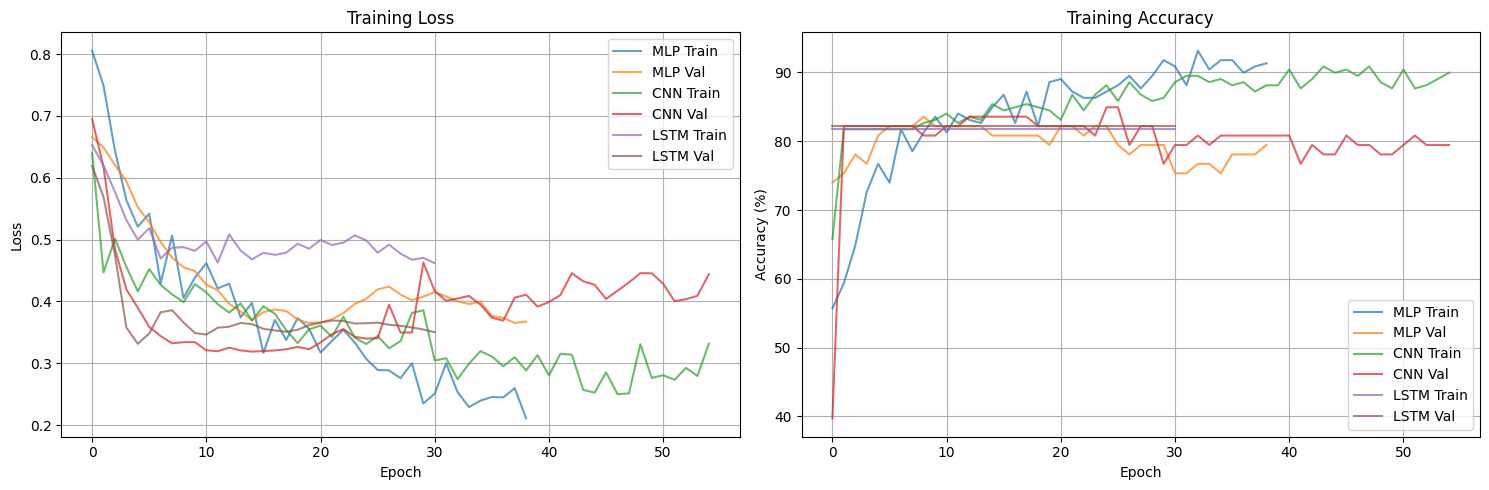


=== Best Performing Weather Model ===
Model: CNN
Test accuracy: 0.8919
Best validation accuracy: 84.93%

CNN model feature importance analysis:
=== Weather Model Feature Importance (Gradient-based) ===
          feature  importance
14    Pressure3pm    0.080279
15       Cloud9am    0.070458
9    WindSpeed9am    0.058741
16       Cloud3pm    0.058395
13    Pressure9am    0.057646
19      RainToday    0.054360
5     WindGustDir    0.052411
11    Humidity9am    0.050853
8      WindDir3pm    0.050562
4        Sunshine    0.048415
2        Rainfall    0.048043
3     Evaporation    0.047440
17        Temp9am    0.045052
6   WindGustSpeed    0.044567
10   WindSpeed3pm    0.044048


In [4]:
# 메인 실행 코드
def main_weather_classification():
    """Weather 분류 메인 함수"""
    # 디바이스 설정
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # 데이터 로드
    file_path = 'dataset/weather/weather.csv'
    df = load_weather_data(file_path)
    
    # 데이터 탐색
    explore_weather_data(df)
    
    # 시각화 생성
    create_weather_visualizations(df)
    
    # 데이터 전처리
    X, y, le_target, le_dict = preprocess_weather_data(df)
    
    # 특성 스케일링
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # 데이터 분할 (훈련/검증/테스트)
    X_temp, X_test, y_temp, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42, stratify=y
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
    )
    
    # pandas Series를 numpy array로 변환
    y_train = y_train.values
    y_val = y_val.values
    y_test = y_test.values
    
    print(f"Training set size: {X_train.shape}")
    print(f"Validation set size: {X_val.shape}")
    print(f"Test set size: {X_test.shape}")
    print()
    
    # PyTorch 모델 정의
    input_size = X_train.shape[1]
    num_classes = len(le_target.classes_)
    models = get_weather_pytorch_models(input_size, num_classes)
    
    # 모델 학습 및 평가
    results, training_histories = train_and_evaluate_weather_models(
        X_train, X_val, X_test, y_train, y_val, y_test, models, le_target, device
    )
    
    # 훈련 히스토리 시각화
    plot_weather_training_history(training_histories)
    
    # 결과 시각화
    plt.figure(figsize=(15, 10))
    
    # 테스트 세트 정확도
    plt.subplot(2, 2, 1)
    model_names = list(results.keys())
    accuracies = [results[name]['accuracy'] for name in model_names]
    bars = plt.bar(model_names, accuracies, color='lightblue', edgecolor='navy')
    plt.title('Weather Models Test Set Accuracy')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45)
    plt.ylim(0.7, 1.0)
    
    # 정확도 값 표시
    for bar, acc in zip(bars, accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
                f'{acc:.3f}', ha='center', va='bottom')
    
    # 최고 검증 정확도 비교
    plt.subplot(2, 2, 2)
    best_val_accs = [training_histories[name]['best_val_acc'] for name in model_names]
    bars = plt.bar(model_names, best_val_accs, color='lightgreen', edgecolor='darkgreen')
    plt.title('Best Validation Accuracy')
    plt.ylabel('Accuracy (%)')
    plt.xticks(rotation=45)
    
    # 정확도 값 표시
    for bar, acc in zip(bars, best_val_accs):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                f'{acc:.1f}%', ha='center', va='bottom')
    
    # 모델별 성능 요약
    plt.subplot(2, 2, 3)
    x = np.arange(len(model_names))
    width = 0.35
    
    plt.bar(x - width/2, accuracies, width, label='Test', alpha=0.7)
    plt.bar(x + width/2, [acc/100 for acc in best_val_accs], width, label='Best Val', alpha=0.7)
    
    plt.title('Model Performance Summary')
    plt.ylabel('Accuracy')
    plt.xlabel('Model')
    plt.xticks(x, model_names, rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 혼동 행렬 시각화 (최고 성능 모델)
    plt.subplot(2, 2, 4)
    best_model_name = max(results, key=lambda x: results[x]['accuracy'])
    cm = results[best_model_name]['confusion_matrix']
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=le_target.classes_, 
                yticklabels=le_target.classes_)
    plt.title(f'Confusion Matrix - {best_model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    plt.tight_layout()
    plt.show()
    
    # 최고 성능 모델 찾기
    best_accuracy = results[best_model_name]['accuracy']
    
    print(f"\n=== Best Performing Weather Model ===")
    print(f"Model: {best_model_name}")
    print(f"Test accuracy: {best_accuracy:.4f}")
    print(f"Best validation accuracy: {training_histories[best_model_name]['best_val_acc']:.2f}%")
    
    # 특성 중요도 분석 (최고 성능 모델)
    print(f"\n{best_model_name} model feature importance analysis:")
    best_model = training_histories[best_model_name]['model']
    feature_names = X.columns.tolist()
    importance_df = analyze_weather_feature_importance(
        best_model, X_scaled, y, feature_names, device
    )
    
    # 예측 확률 분포 시각화
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    probabilities = results[best_model_name]['probabilities']
    rain_probs = [prob[1] for prob in probabilities]  # 비 올 확률
    plt.hist(rain_probs, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    plt.title('Predicted Rain Probability Distribution')
    plt.xlabel('Predicted Rain Probability')
    plt.ylabel('Frequency')
    plt.axvline(x=0.5, color='red', linestyle='--', label='Decision Threshold')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    # 실제 레이블별 예측 확률 분포
    labels = results[best_model_name]['labels']
    no_rain_probs = [rain_probs[i] for i in range(len(rain_probs)) if labels[i] == 0]
    rain_probs_actual = [rain_probs[i] for i in range(len(rain_probs)) if labels[i] == 1]
    
    plt.hist(no_rain_probs, bins=30, alpha=0.7, label='No Rain', color='lightcoral')
    plt.hist(rain_probs_actual, bins=30, alpha=0.7, label='Rain', color='lightblue')
    plt.title('Predicted Probability by Actual Label')
    plt.xlabel('Predicted Rain Probability')
    plt.ylabel('Frequency')
    plt.legend()
    plt.axvline(x=0.5, color='red', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    return results, training_histories, importance_df

# 실행
if __name__ == "__main__":
    results, training_histories, importance_df = main_weather_classification()


In [5]:
# Weather 회귀 모델 (Rainfall 예측)
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
import torch.nn.init as init

# 데이터 로드 함수
def load_weather_data_regression(file_path):
    """Weather 데이터셋을 로드하는 함수 (회귀용)"""
    df = pd.read_csv(file_path)
    return df

# 데이터 전처리 함수 (회귀용)
def preprocess_weather_data_regression(df):
    """Weather 데이터 전처리를 수행하는 함수 (회귀용)"""
    print("=== Data Preprocessing for Regression ===")
    print(f"Original data shape: {df.shape}")
    
    # 결측값 확인
    print("\nMissing values check:")
    missing_values = df.isnull().sum()
    print(missing_values[missing_values > 0])
    
    # 'NA' 값을 NaN으로 변환
    df = df.replace('NA', np.nan)
    
    # 숫자형 컬럼의 결측값을 평균으로 채우기
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    for col in numeric_columns:
        if df[col].isnull().sum() > 0:
            df[col].fillna(df[col].mean(), inplace=True)
    
    # 범주형 컬럼의 결측값을 최빈값으로 채우기
    categorical_columns = df.select_dtypes(include=['object']).columns
    for col in categorical_columns:
        if df[col].isnull().sum() > 0:
            df[col].fillna(df[col].mode()[0], inplace=True)
    
    # 불필요한 컬럼 제거 (Date, Location, RISK_MM, RainTomorrow)
    df = df.drop(['Date', 'Location', 'RISK_MM', 'RainTomorrow'], axis=1, errors='ignore')
    
    # 범주형 변수 인코딩
    le_dict = {}
    for col in df.select_dtypes(include=['object']).columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        le_dict[col] = le
    
    # 특성과 타겟 분리 (Rainfall이 타겟)
    X = df.drop('Rainfall', axis=1)
    y = df['Rainfall']
    
    print(f"\nAfter preprocessing:")
    print(f"Features shape: {X.shape}")
    print(f"Target shape: {y.shape}")
    print(f"Target statistics:")
    print(f"  Mean: {y.mean():.3f}")
    print(f"  Std: {y.std():.3f}")
    print(f"  Min: {y.min():.3f}")
    print(f"  Max: {y.max():.3f}")
    
    return X, y, le_dict

# 데이터 탐색 함수 (회귀용)
def explore_weather_data_regression(df):
    """Weather 데이터 탐색을 수행하는 함수 (회귀용)"""
    print("=== Weather Dataset Basic Information (Regression) ===")
    print(f"Data shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    
    print("\n=== Target (Rainfall) Distribution ===")
    print(f"Rainfall statistics:")
    print(f"  Mean: {df['Rainfall'].mean():.3f}")
    print(f"  Median: {df['Rainfall'].median():.3f}")
    print(f"  Std: {df['Rainfall'].std():.3f}")
    print(f"  Min: {df['Rainfall'].min():.3f}")
    print(f"  Max: {df['Rainfall'].max():.3f}")
    
    print("\n=== Basic Statistics ===")
    print(df.describe())
    
    print("\n=== Missing Values ===")
    missing_values = df.isnull().sum()
    print(missing_values[missing_values > 0])
    
    return df

# PyTorch 회귀 모델 정의
class WeatherMLPRegressor(nn.Module):
    """Weather 예측을 위한 다층 퍼셉트론 회귀기"""
    def __init__(self, input_size, hidden_sizes=[256, 128, 64, 32], dropout_rate=0.3):
        super(WeatherMLPRegressor, self).__init__()
        
        layers = []
        prev_size = input_size
        
        for hidden_size in hidden_sizes:
            layers.extend([
                nn.Linear(prev_size, hidden_size),
                nn.BatchNorm1d(hidden_size),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ])
            prev_size = hidden_size
        
        layers.append(nn.Linear(prev_size, 1))  # 회귀는 출력이 1개
        self.network = nn.Sequential(*layers)
        
        # 가중치 초기화
        self.apply(self._init_weights)
    
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            init.xavier_uniform_(m.weight)
            init.constant_(m.bias, 0)
    
    def forward(self, x):
        return self.network(x).squeeze()  # 차원 축소

class WeatherCNNRegressor(nn.Module):
    """Weather 예측을 위한 1D CNN 회귀기"""
    def __init__(self, input_size, dropout_rate=0.3):
        super(WeatherCNNRegressor, self).__init__()
        
        # 1D CNN layers
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(256)
        
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(dropout_rate)
        
        # Fully connected layers
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)  # 회귀는 출력이 1개
        
    def forward(self, x):
        # x shape: (batch_size, input_size) -> (batch_size, 1, input_size)
        x = x.unsqueeze(1)
        
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.dropout(x)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.dropout(x)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x.squeeze()  # 차원 축소

class WeatherLSTMRegressor(nn.Module):
    """Weather 예측을 위한 LSTM 회귀기"""
    def __init__(self, input_size, hidden_size=128, num_layers=3, dropout_rate=0.3):
        super(WeatherLSTMRegressor, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                           batch_first=True, dropout=dropout_rate if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout_rate)
        
        # Attention mechanism
        self.attention = nn.MultiheadAttention(hidden_size, num_heads=8, dropout=dropout_rate)
        
        self.fc1 = nn.Linear(hidden_size, 64)
        self.fc2 = nn.Linear(64, 1)  # 회귀는 출력이 1개
        
    def forward(self, x):
        # x shape: (batch_size, input_size) -> (batch_size, 1, input_size)
        x = x.unsqueeze(1)
        
        # LSTM forward pass
        lstm_out, _ = self.lstm(x)
        
        # Self-attention
        attn_output, _ = self.attention(lstm_out, lstm_out, lstm_out)
        
        # Global average pooling
        output = attn_output.mean(dim=1)
        output = self.dropout(output)
        
        output = F.relu(self.fc1(output))
        output = self.dropout(output)
        output = self.fc2(output)
        
        return output.squeeze()  # 차원 축소

# PyTorch 데이터셋 클래스 (회귀용)
class WeatherRegressionDataset(Dataset):
    """Weather 회귀 데이터셋을 위한 PyTorch Dataset"""
    def __init__(self, features, targets):
        self.features = torch.FloatTensor(features)
        self.targets = torch.FloatTensor(targets)
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

# PyTorch 회귀 모델들을 정의하는 함수
def get_weather_pytorch_regressors(input_size):
    """다양한 Weather PyTorch 회귀 모델들을 반환하는 함수"""
    models = {
        'MLP': WeatherMLPRegressor(input_size, [256, 128, 64, 32]),
        'CNN': WeatherCNNRegressor(input_size),
        'LSTM': WeatherLSTMRegressor(input_size, 128, 3)
    }
    return models


In [6]:
# PyTorch 회귀 모델 훈련 함수
def train_weather_regressor(model, train_loader, val_loader, num_epochs=150, learning_rate=0.001, device='cpu'):
    """Weather PyTorch 회귀 모델을 훈련하는 함수"""
    model = model.to(device)
    criterion = nn.MSELoss()  # 회귀는 MSE Loss 사용
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=15, factor=0.5)
    
    train_losses = []
    val_losses = []
    train_maes = []
    val_maes = []
    
    best_val_loss = float('inf')
    best_model_state = None
    patience_counter = 0
    early_stopping_patience = 30
    
    for epoch in range(num_epochs):
        # 훈련 모드
        model.train()
        train_loss = 0
        train_mae = 0
        train_total = 0
        
        for batch_features, batch_targets in train_loader:
            batch_features, batch_targets = batch_features.to(device), batch_targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_features)
            loss = criterion(outputs, batch_targets)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_mae += F.l1_loss(outputs, batch_targets).item()
            train_total += batch_targets.size(0)
        
        # 검증 모드
        model.eval()
        val_loss = 0
        val_mae = 0
        val_total = 0
        
        with torch.no_grad():
            for batch_features, batch_targets in val_loader:
                batch_features, batch_targets = batch_features.to(device), batch_targets.to(device)
                outputs = model(batch_features)
                loss = criterion(outputs, batch_targets)
                
                val_loss += loss.item()
                val_mae += F.l1_loss(outputs, batch_targets).item()
                val_total += batch_targets.size(0)
        
        # 평균 계산
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        avg_train_mae = train_mae / len(train_loader)
        avg_val_mae = val_mae / len(val_loader)
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_maes.append(avg_train_mae)
        val_maes.append(avg_val_mae)
        
        # 학습률 스케줄링
        scheduler.step(avg_val_loss)
        
        # 최고 성능 모델 저장
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
        
        # Early stopping
        if patience_counter >= early_stopping_patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
        
        # 진행 상황 출력 (20 에포크마다)
        if (epoch + 1) % 20 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {avg_train_loss:.4f}, Train MAE: {avg_train_mae:.4f}, '
                  f'Val Loss: {avg_val_loss:.4f}, Val MAE: {avg_val_mae:.4f}')
    
    # 최고 성능 모델 로드
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return {
        'model': model,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_maes': train_maes,
        'val_maes': val_maes,
        'best_val_loss': best_val_loss
    }

# PyTorch 회귀 모델 평가 함수
def evaluate_weather_regressor(model, test_loader, device='cpu'):
    """Weather PyTorch 회귀 모델을 평가하는 함수"""
    model.eval()
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for batch_features, batch_targets in test_loader:
            batch_features, batch_targets = batch_features.to(device), batch_targets.to(device)
            outputs = model(batch_features)
            
            all_predictions.extend(outputs.cpu().numpy())
            all_targets.extend(batch_targets.cpu().numpy())
    
    # 회귀 메트릭 계산
    mse = mean_squared_error(all_targets, all_predictions)
    mae = mean_absolute_error(all_targets, all_predictions)
    r2 = r2_score(all_targets, all_predictions)
    rmse = np.sqrt(mse)
    
    return mse, mae, r2, rmse, all_predictions, all_targets

# PyTorch 회귀 모델들을 학습하고 평가하는 함수
def train_and_evaluate_weather_regressors(X_train, X_val, X_test, y_train, y_val, y_test, models, device='cpu'):
    """Weather PyTorch 회귀 모델들을 학습하고 평가하는 함수"""
    results = {}
    training_histories = {}
    
    print("=== Weather PyTorch Regression Model Performance Evaluation ===")
    print("-" * 80)
    
    # 데이터로더 생성
    train_dataset = WeatherRegressionDataset(X_train, y_train)
    val_dataset = WeatherRegressionDataset(X_val, y_val)
    test_dataset = WeatherRegressionDataset(X_test, y_test)
    
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    
    for name, model in models.items():
        print(f"\n{name} model training...")
        
        # 모델 훈련
        training_result = train_weather_regressor(model, train_loader, val_loader, device=device)
        training_histories[name] = training_result
        
        # 모델 평가
        mse, mae, r2, rmse, predictions, targets = evaluate_weather_regressor(
            training_result['model'], test_loader, device
        )
        
        results[name] = {
            'mse': mse,
            'mae': mae,
            'r2': r2,
            'rmse': rmse,
            'predictions': predictions,
            'targets': targets
        }
        
        print(f"\n{name} model results:")
        print(f"Test MSE: {mse:.4f}")
        print(f"Test MAE: {mae:.4f}")
        print(f"Test R²: {r2:.4f}")
        print(f"Test RMSE: {rmse:.4f}")
        print(f"Best validation loss: {training_result['best_val_loss']:.4f}")
        print("-" * 80)
    
    return results, training_histories

# 훈련 히스토리 시각화 함수 (회귀용)
def plot_weather_regression_training_history(training_histories):
    """Weather 회귀 훈련 히스토리를 시각화하는 함수"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    for i, (name, history) in enumerate(training_histories.items()):
        # Loss 그래프
        axes[0].plot(history['train_losses'], label=f'{name} Train', alpha=0.7)
        axes[0].plot(history['val_losses'], label=f'{name} Val', alpha=0.7)
        axes[0].set_title('Training Loss (MSE)')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')
        axes[0].legend()
        axes[0].grid(True)
        
        # MAE 그래프
        axes[1].plot(history['train_maes'], label=f'{name} Train', alpha=0.7)
        axes[1].plot(history['val_maes'], label=f'{name} Val', alpha=0.7)
        axes[1].set_title('Training MAE')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('MAE')
        axes[1].legend()
        axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()

# 회귀 결과 시각화 함수
def plot_regression_results(results, training_histories):
    """회귀 결과를 시각화하는 함수"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    model_names = list(results.keys())
    
    # R² 점수 비교
    r2_scores = [results[name]['r2'] for name in model_names]
    bars = axes[0, 0].bar(model_names, r2_scores, color='lightblue', edgecolor='navy')
    axes[0, 0].set_title('R² Score Comparison')
    axes[0, 0].set_ylabel('R² Score')
    axes[0, 0].set_ylim(0, 1)
    
    for bar, score in zip(bars, r2_scores):
        axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                       f'{score:.3f}', ha='center', va='bottom')
    
    # RMSE 비교
    rmse_scores = [results[name]['rmse'] for name in model_names]
    bars = axes[0, 1].bar(model_names, rmse_scores, color='lightcoral', edgecolor='darkred')
    axes[0, 1].set_title('RMSE Comparison')
    axes[0, 1].set_ylabel('RMSE')
    
    for bar, score in zip(bars, rmse_scores):
        axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                       f'{score:.3f}', ha='center', va='bottom')
    
    # MAE 비교
    mae_scores = [results[name]['mae'] for name in model_names]
    bars = axes[1, 0].bar(model_names, mae_scores, color='lightgreen', edgecolor='darkgreen')
    axes[1, 0].set_title('MAE Comparison')
    axes[1, 0].set_ylabel('MAE')
    
    for bar, score in zip(bars, mae_scores):
        axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                       f'{score:.3f}', ha='center', va='bottom')
    
    # 실제 vs 예측 (최고 성능 모델)
    best_model_name = max(results, key=lambda x: results[x]['r2'])
    targets = results[best_model_name]['targets']
    predictions = results[best_model_name]['predictions']
    
    axes[1, 1].scatter(targets, predictions, alpha=0.6, color='blue')
    axes[1, 1].plot([targets.min(), targets.max()], [targets.min(), targets.max()], 'r--', lw=2)
    axes[1, 1].set_xlabel('Actual Rainfall')
    axes[1, 1].set_ylabel('Predicted Rainfall')
    axes[1, 1].set_title(f'Actual vs Predicted - {best_model_name}')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return best_model_name


Using device: cuda
=== Weather Dataset Basic Information (Regression) ===
Data shape: (366, 24)
Columns: ['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'RISK_MM', 'RainTomorrow']

=== Target (Rainfall) Distribution ===
Rainfall statistics:
  Mean: 1.428
  Median: 0.000
  Std: 4.226
  Min: 0.000
  Max: 39.800

=== Basic Statistics ===
          MinTemp     MaxTemp    Rainfall  Evaporation    Sunshine  \
count  366.000000  366.000000  366.000000   366.000000  363.000000   
mean     7.265574   20.550273    1.428415     4.521858    7.909366   
std      6.025800    6.690516    4.225800     2.669383    3.481517   
min     -5.300000    7.600000    0.000000     0.200000    0.000000   
25%      2.300000   15.025000    0.000000     2.200000    5.950000  

/tmp/ipykernel_816810/3171150492.py:42: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mean(), inplace=True)
/tmp/ipykernel_816810/3171150492.py:48: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', tr

Epoch [20/150], Train Loss: 5.7707, Train MAE: 1.2038, Val Loss: 10.8510, Val MAE: 1.3588
Epoch [40/150], Train Loss: 3.6037, Train MAE: 1.0269, Val Loss: 11.2896, Val MAE: 1.4165
Epoch [60/150], Train Loss: 2.8845, Train MAE: 0.8708, Val Loss: 9.5440, Val MAE: 1.2999
Epoch [80/150], Train Loss: 1.3780, Train MAE: 0.7416, Val Loss: 11.7251, Val MAE: 1.4821
Epoch [100/150], Train Loss: 1.4134, Train MAE: 0.6875, Val Loss: 9.6244, Val MAE: 1.3461
Epoch [120/150], Train Loss: 2.1134, Train MAE: 0.7364, Val Loss: 9.6529, Val MAE: 1.3374
Epoch [140/150], Train Loss: 2.5323, Train MAE: 0.7951, Val Loss: 9.5692, Val MAE: 1.3255
Early stopping at epoch 142

MLP model results:
Test MSE: 27.3518
Test MAE: 1.8226
Test R²: 0.3530
Test RMSE: 5.2299
Best validation loss: 9.1081
--------------------------------------------------------------------------------

CNN model training...
Epoch [20/150], Train Loss: 6.7971, Train MAE: 1.0664, Val Loss: 10.9554, Val MAE: 1.3494
Epoch [40/150], Train Loss: 4.1

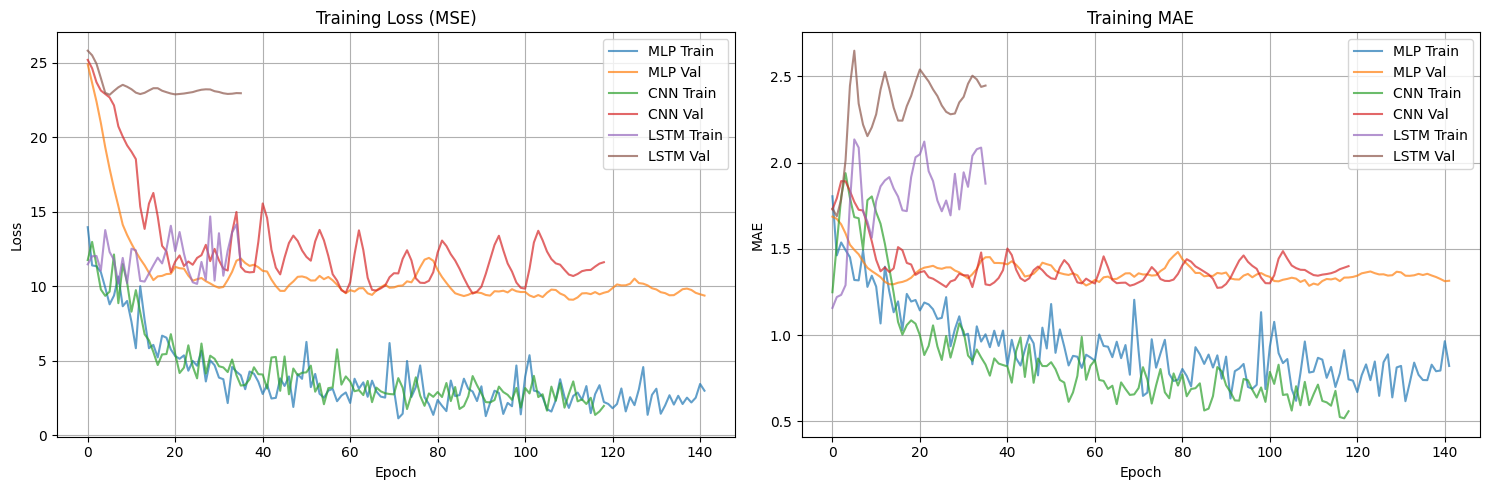

AttributeError: 'list' object has no attribute 'min'

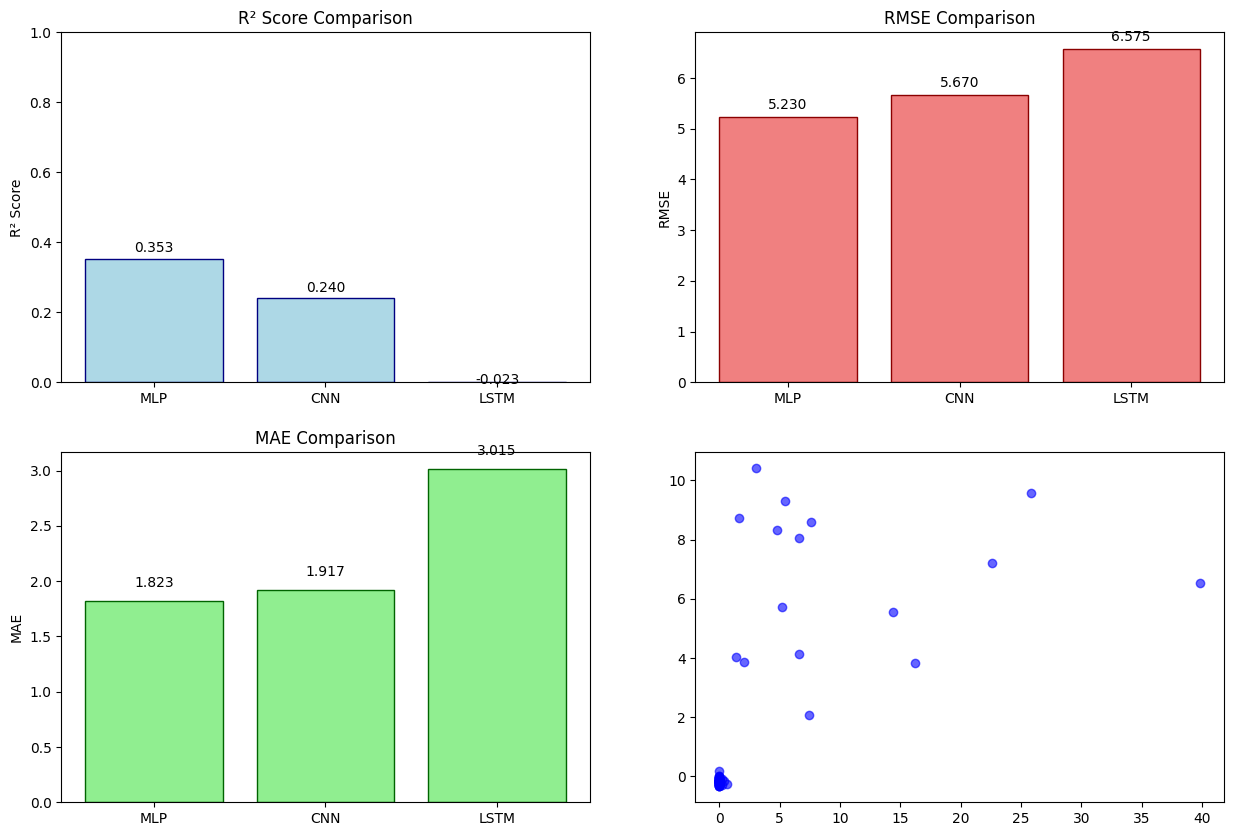

In [7]:
# 메인 회귀 실행 함수
def main_weather_regression():
    """Weather 회귀 메인 함수"""
    # 디바이스 설정
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # 데이터 로드
    file_path = 'dataset/weather/weather.csv'
    df = load_weather_data_regression(file_path)
    
    # 데이터 탐색
    explore_weather_data_regression(df)
    
    # 데이터 전처리
    X, y, le_dict = preprocess_weather_data_regression(df)
    
    # 특성 스케일링
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # 데이터 분할 (훈련/검증/테스트)
    X_temp, X_test, y_temp, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.25, random_state=42
    )
    
    # pandas Series를 numpy array로 변환
    y_train = y_train.values
    y_val = y_val.values
    y_test = y_test.values
    
    print(f"Training set size: {X_train.shape}")
    print(f"Validation set size: {X_val.shape}")
    print(f"Test set size: {X_test.shape}")
    print()
    
    # PyTorch 회귀 모델 정의
    input_size = X_train.shape[1]
    models = get_weather_pytorch_regressors(input_size)
    
    # 모델 학습 및 평가
    results, training_histories = train_and_evaluate_weather_regressors(
        X_train, X_val, X_test, y_train, y_val, y_test, models, device
    )
    
    # 훈련 히스토리 시각화
    plot_weather_regression_training_history(training_histories)
    
    # 결과 시각화
    best_model_name = plot_regression_results(results, training_histories)
    
    # 최고 성능 모델 정보 출력
    best_r2 = results[best_model_name]['r2']
    best_rmse = results[best_model_name]['rmse']
    best_mae = results[best_model_name]['mae']
    
    print(f"\n=== Best Performing Weather Regression Model ===")
    print(f"Model: {best_model_name}")
    print(f"Test R²: {best_r2:.4f}")
    print(f"Test RMSE: {best_rmse:.4f}")
    print(f"Test MAE: {best_mae:.4f}")
    print(f"Best validation loss: {training_histories[best_model_name]['best_val_loss']:.4f}")
    
    # 예측 오차 분석
    targets = results[best_model_name]['targets']
    predictions = results[best_model_name]['predictions']
    errors = np.abs(targets - predictions)
    
    print(f"\n=== Prediction Error Analysis ===")
    print(f"Mean absolute error: {np.mean(errors):.4f}")
    print(f"Median absolute error: {np.median(errors):.4f}")
    print(f"Max absolute error: {np.max(errors):.4f}")
    print(f"Error std: {np.std(errors):.4f}")
    
    # 오차 분포 시각화
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.hist(errors, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    plt.title('Prediction Error Distribution')
    plt.xlabel('Absolute Error')
    plt.ylabel('Frequency')
    plt.axvline(x=np.mean(errors), color='red', linestyle='--', label=f'Mean: {np.mean(errors):.3f}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    # 오차 vs 실제값
    plt.scatter(targets, errors, alpha=0.6, color='blue')
    plt.xlabel('Actual Rainfall')
    plt.ylabel('Absolute Error')
    plt.title('Error vs Actual Value')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return results, training_histories

# 실행
if __name__ == "__main__":
    results, training_histories = main_weather_regression()


In [ ]:
# Weather 회귀 모델 실행
main_weather_regression()


Using device: cuda
=== Weather Dataset Basic Information ===
Data shape: (366, 24)
Columns: ['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'RISK_MM', 'RainTomorrow']

=== Target Distribution ===
RainTomorrow
No     300
Yes     66
Name: count, dtype: int64
Rain probability: 0.180

=== Basic Statistics ===
          MinTemp     MaxTemp    Rainfall  Evaporation    Sunshine  \
count  366.000000  366.000000  366.000000   366.000000  363.000000   
mean     7.265574   20.550273    1.428415     4.521858    7.909366   
std      6.025800    6.690516    4.225800     2.669383    3.481517   
min     -5.300000    7.600000    0.000000     0.200000    0.000000   
25%      2.300000   15.025000    0.000000     2.200000    5.950000   
50%      7.450000   19.65000

/tmp/ipykernel_814152/1898842108.py:41: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mean(), inplace=True)
/tmp/ipykernel_814152/1898842108.py:47: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', tr

Epoch [20/150], Train Loss: 0.3433, Train Acc: 84.02%, Val Loss: 0.3946, Val Acc: 79.45%
Early stopping at epoch 34

MLP model results:
Test accuracy: 0.8243
Best validation accuracy: 82.19%
Classification report:
              precision    recall  f1-score   support

          No       0.91      0.87      0.89        61
         Yes       0.50      0.62      0.55        13

    accuracy                           0.82        74
   macro avg       0.71      0.74      0.72        74
weighted avg       0.84      0.82      0.83        74

Confusion matrix:
[[53  8]
 [ 5  8]]
--------------------------------------------------------------------------------

CNN model training...
Epoch [20/150], Train Loss: 0.3520, Train Acc: 85.39%, Val Loss: 0.3391, Val Acc: 83.56%
Epoch [40/150], Train Loss: 0.2733, Train Acc: 89.04%, Val Loss: 0.3749, Val Acc: 82.19%
Early stopping at epoch 59

CNN model results:
Test accuracy: 0.8378
Best validation accuracy: 86.30%
Classification report:
              p

/home/luili0307/Desktop/Code/Machine_Learning/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/luili0307/Desktop/Code/Machine_Learning/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/luili0307/Desktop/Code/Machine_Learning/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

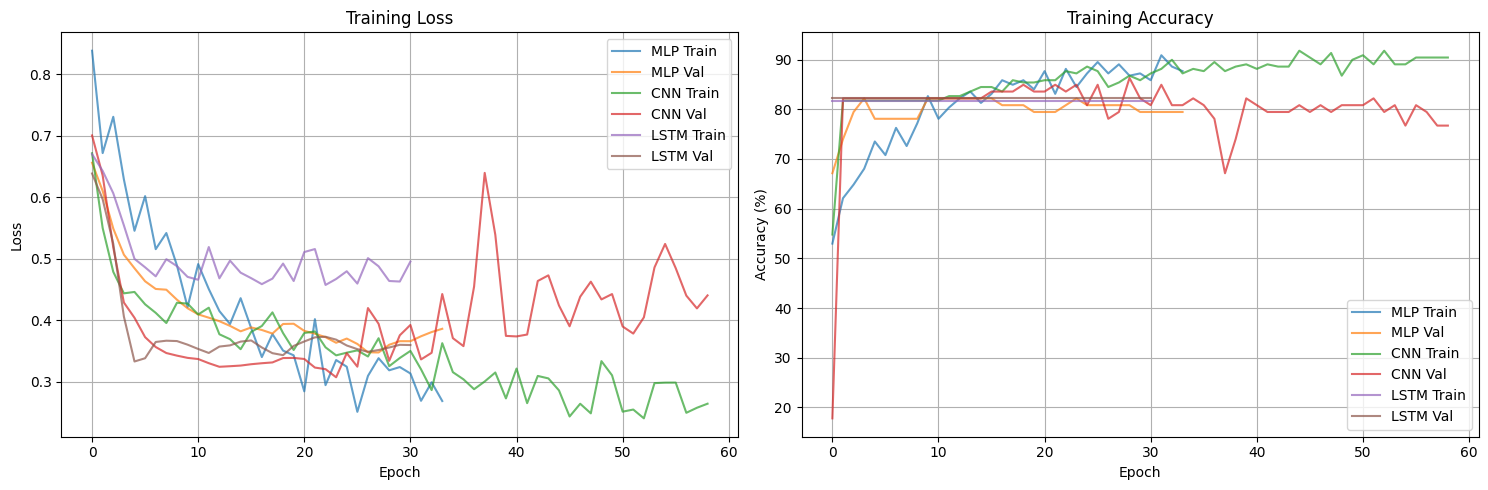

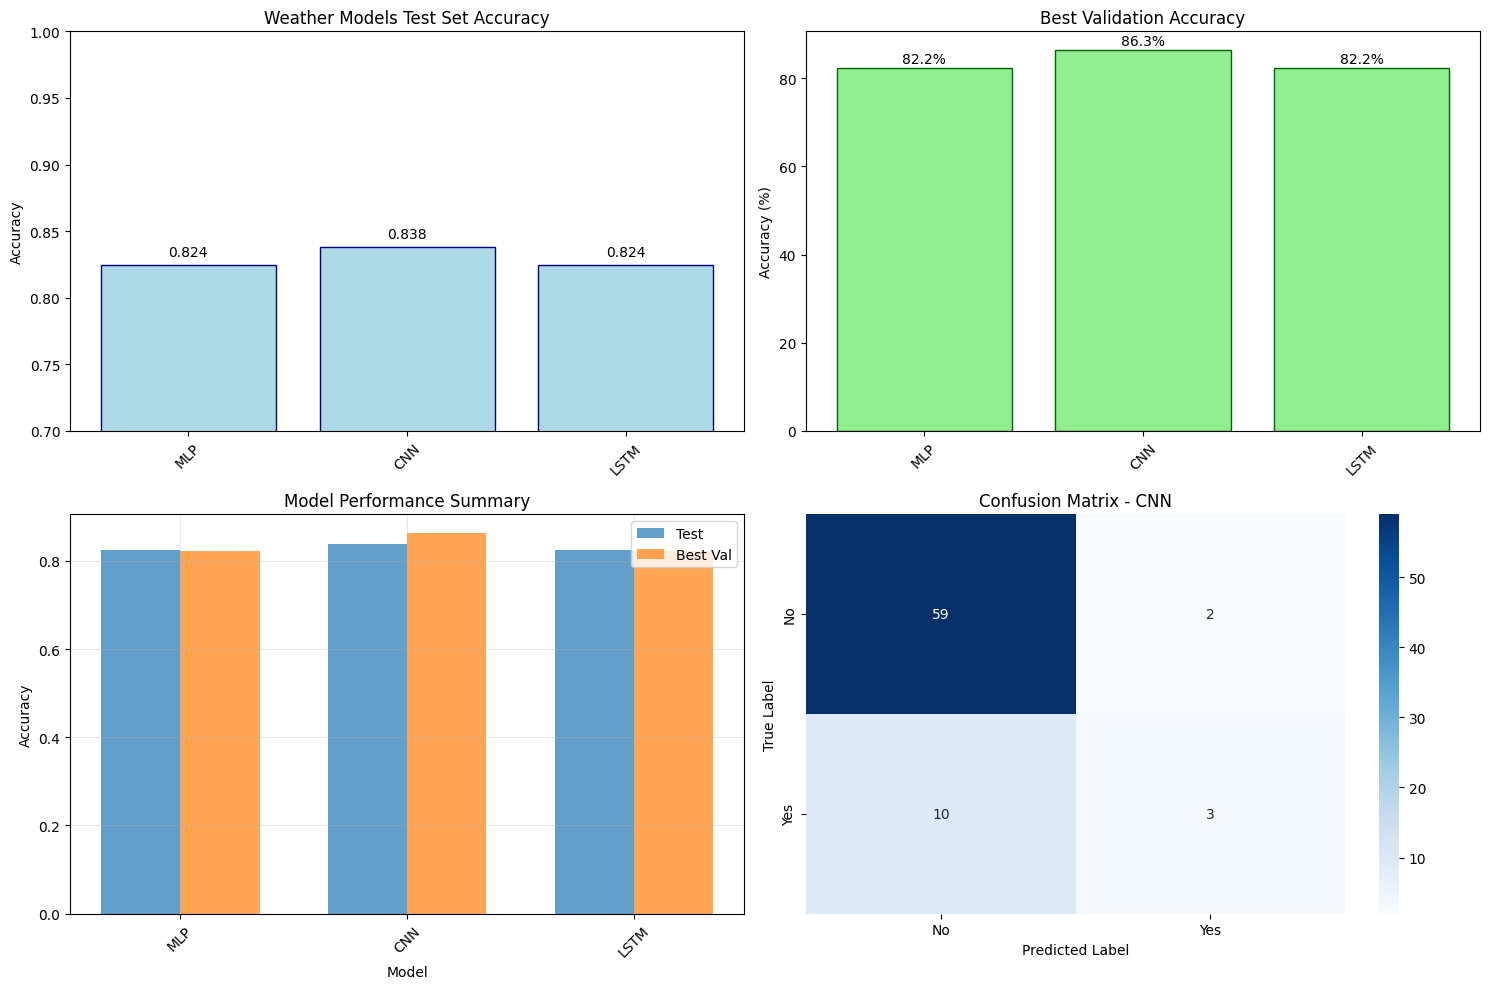


=== Best Performing Weather Model ===
Model: CNN
Test accuracy: 0.8378
Best validation accuracy: 86.30%

CNN model feature importance analysis:
=== Weather Model Feature Importance (Gradient-based) ===
          feature  importance
14    Pressure3pm    0.073430
15       Cloud9am    0.066221
16       Cloud3pm    0.060926
9    WindSpeed9am    0.059950
13    Pressure9am    0.057503
11    Humidity9am    0.051528
8      WindDir3pm    0.051085
5     WindGustDir    0.050707
3     Evaporation    0.050563
4        Sunshine    0.049825
6   WindGustSpeed    0.048099
19      RainToday    0.047254
17        Temp9am    0.046555
2        Rainfall    0.045920
0         MinTemp    0.042338


/tmp/ipykernel_814152/2056071577.py:250: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_features, x='importance', y='feature', palette='viridis')


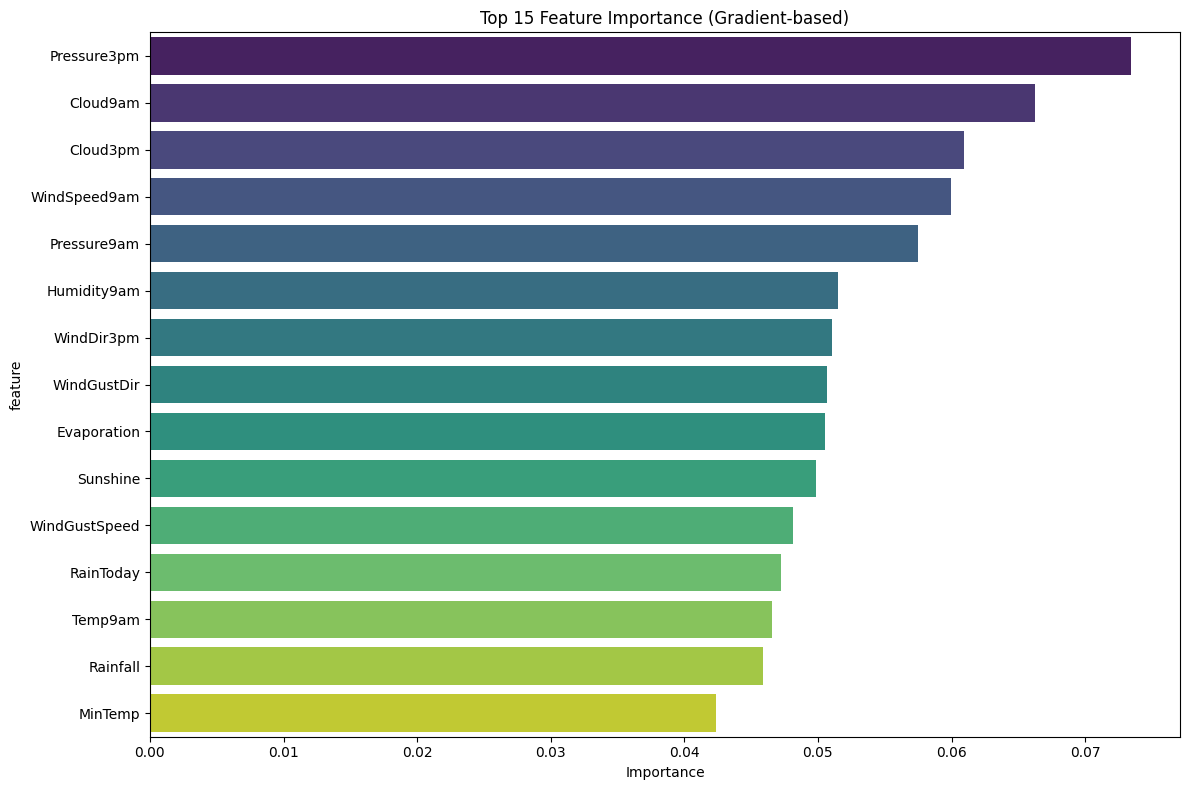

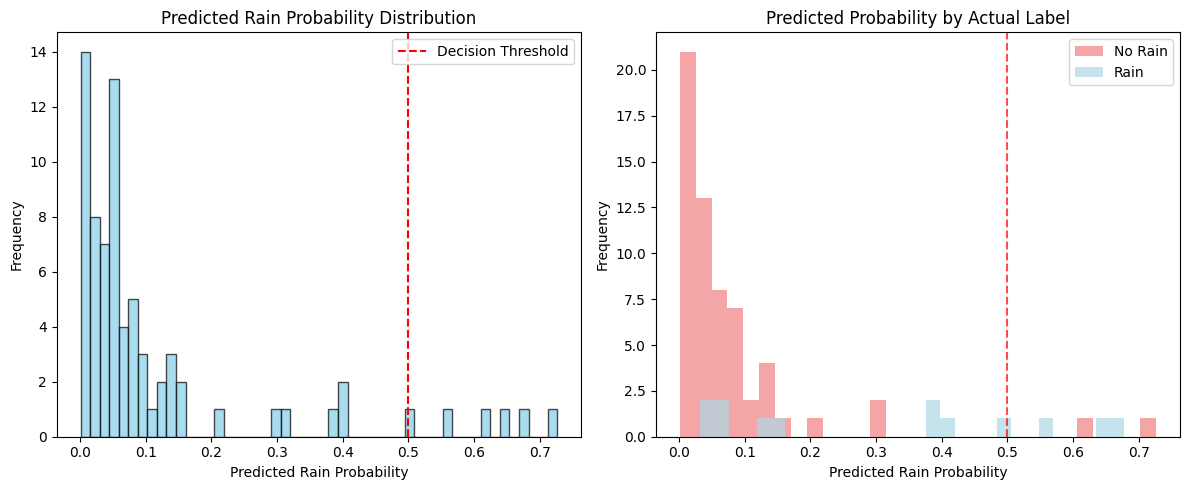

({'MLP': {'accuracy': 0.8243243243243243,
   'report': {'No': {'precision': 0.9137931034482759,
     'recall': 0.8688524590163934,
     'f1-score': 0.8907563025210085,
     'support': 61.0},
    'Yes': {'precision': 0.5,
     'recall': 0.6153846153846154,
     'f1-score': 0.5517241379310345,
     'support': 13.0},
    'accuracy': 0.8243243243243243,
    'macro avg': {'precision': 0.7068965517241379,
     'recall': 0.7421185372005044,
     'f1-score': 0.7212402202260215,
     'support': 74.0},
    'weighted avg': {'precision': 0.8410997204100653,
     'recall': 0.8243243243243243,
     'f1-score': 0.831196597930878,
     'support': 74.0}},
   'confusion_matrix': array([[53,  8],
          [ 5,  8]]),
   'predictions': [0,
    0,
    0,
    0,
    1,
    0,
    1,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    1,
    1,
    0,
    0,
    0,
    1,
    0,
    0,
    0,
    1,
    1,
    0,
    0,
    0,
    0,
    1,
    0,
    0,
    1,
    1,
    0,
   

In [ ]:
# 직접 실행
main_weather_classification()


In [ ]:
# 간소화된 회귀 결과 시각화 함수
def plot_regression_results_simple(results, training_histories):
    """회귀 결과를 시각화하는 함수 - 간소화된 버전"""
    # 모든 결과 시각화 제거
    best_model_name = max(results, key=lambda x: results[x]['r2'])
    return best_model_name

# 간소화된 메인 회귀 실행 함수
def main_weather_regression_simple():
    """Weather 회귀 메인 함수 - 간소화된 버전"""
    # 디바이스 설정
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # 데이터 로드
    file_path = 'dataset/weather/weather.csv'
    df = load_weather_data_regression(file_path)
    
    # 데이터 탐색
    explore_weather_data_regression(df)
    
    # 데이터 전처리
    X, y, le_dict = preprocess_weather_data_regression(df)
    
    # 특성 스케일링
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # 데이터 분할 (훈련/검증/테스트)
    X_temp, X_test, y_temp, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.25, random_state=42
    )
    
    # pandas Series를 numpy array로 변환
    y_train = y_train.values
    y_val = y_val.values
    y_test = y_test.values
    
    print(f"Training set size: {X_train.shape}")
    print(f"Validation set size: {X_val.shape}")
    print(f"Test set size: {X_test.shape}")
    print()
    
    # PyTorch 회귀 모델 정의
    input_size = X_train.shape[1]
    models = get_weather_pytorch_regressors(input_size)
    
    # 모델 학습 및 평가
    results, training_histories = train_and_evaluate_weather_regressors(
        X_train, X_val, X_test, y_train, y_val, y_test, models, device
    )
    
    # 훈련 히스토리 시각화 (Loss와 MAE만)
    plot_weather_regression_training_history(training_histories)
    
    # 결과 시각화 제거
    best_model_name = plot_regression_results_simple(results, training_histories)
    
    # 최고 성능 모델 정보 출력
    best_r2 = results[best_model_name]['r2']
    best_rmse = results[best_model_name]['rmse']
    best_mae = results[best_model_name]['mae']
    
    print(f"\n=== Best Performing Weather Regression Model ===")
    print(f"Model: {best_model_name}")
    print(f"Test R²: {best_r2:.4f}")
    print(f"Test RMSE: {best_rmse:.4f}")
    print(f"Test MAE: {best_mae:.4f}")
    print(f"Best validation loss: {training_histories[best_model_name]['best_val_loss']:.4f}")
    
    # 예측 오차 분석 (시각화 제거)
    targets = results[best_model_name]['targets']
    predictions = results[best_model_name]['predictions']
    errors = np.abs(targets - predictions)
    
    print(f"\n=== Prediction Error Analysis ===")
    print(f"Mean absolute error: {np.mean(errors):.4f}")
    print(f"Median absolute error: {np.median(errors):.4f}")
    print(f"Max absolute error: {np.max(errors):.4f}")
    print(f"Error std: {np.std(errors):.4f}")
    
    return results, training_histories

# 간소화된 회귀 모델 실행
main_weather_regression_simple()
